In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time

from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
from sklearn.neighbors import KernelDensity
import statsmodels.api as sma

from scipy.integrate import quad
from scipy.interpolate import interp1d

from SyntheticDataModule import *
from IHDPDataModule import *
from estimators import *
from utils import *
from mmr_utils import *

<Axes: >

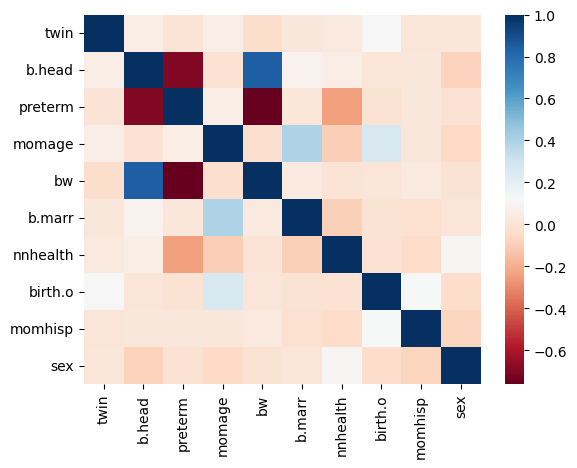

In [2]:
ORIG_COL_NAMES = ["twin", "b.head", "preterm", "momage", "bw", "b.marr", "nnhealth", "birth.o", "momhisp", "sex"]
CONT_COLS = ["b.head", "preterm", "momage", "bw", "nnhealth", "birth.o"]
DISC_COLS = ["twin", "b.marr", "momhisp", "sex"]
COL_NAME_DICT = {f"X{i+1}": col  for i,col in enumerate(ORIG_COL_NAMES)}

ihdp_df = pd.read_csv('data/ihdp/ihdp.csv')[ORIG_COL_NAMES]

scaler = MinMaxScaler()
ihdp_df[CONT_COLS] = scaler.fit_transform(ihdp_df[CONT_COLS])
ihdp_df[DISC_COLS] = ihdp_df[DISC_COLS] - 0.5

sns.heatmap(ihdp_df.corr(), cmap='RdBu')

RCT size: 985, OS size: 1970, time elapsed: 49.32


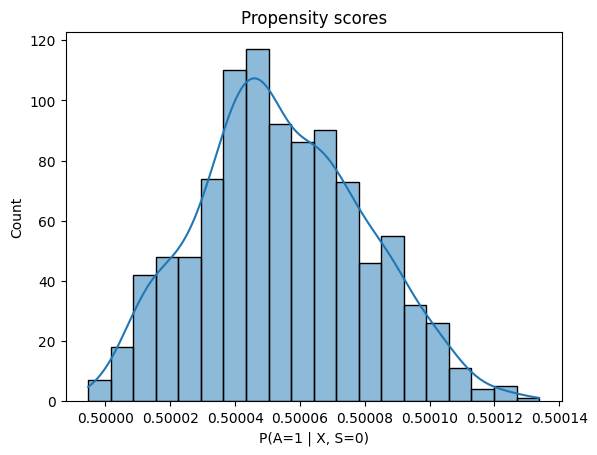

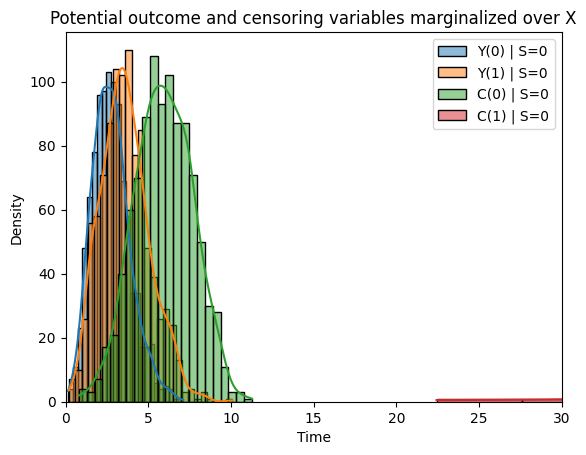

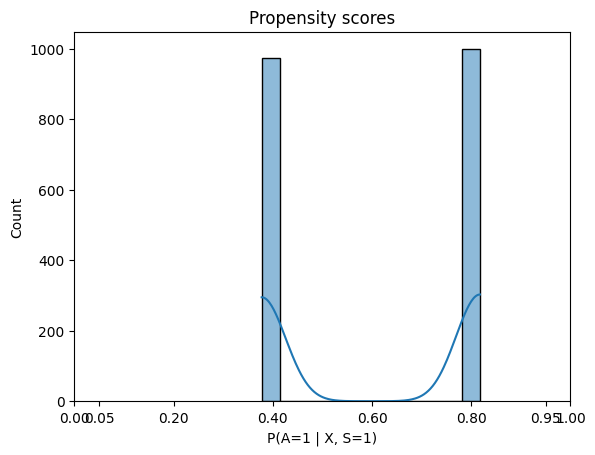

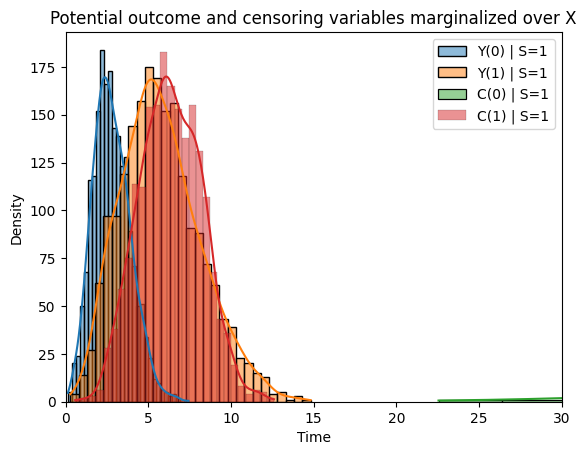

In [4]:
mmr_keys = ["CDR", "IPW-Drop"]
CD = 10
UC = 0
jD = read_json('ihdp/diffPOihdp-highdiff.json', CD, UC, mmr_keys)

m = 2
os_size = int(jD['rct_size'] * m)

t1 = time()

df_combined, df_comb_drop, RCTData, OSData = generate_data(CD, os_size, jD)
Fb_Y, Gb_C = est_nuisance(df_combined, df_comb_drop, jD)

print('RCT size: {}, OS size: {}, time elapsed: {:.2f}'.format(jD['rct_size'], os_size, time() - t1))

summary_df = pd.concat([RCTData.summary(plot=True), OSData.summary(plot=True)], axis=0, ignore_index=True)
summary_df

crop_prop = True

mmr_stats = np.zeros((len(mmr_keys), 2))  # store results and p-val for each mmr test

for kind, key in enumerate(mmr_keys):
    if 'Drop' in key:
        df_mmr = df_comb_drop.copy()
    else:
        df_mmr = df_combined.copy()

    if jD['crop_prop'] and ('Drop' not in key):
        df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95) &\
                (1e-4 < df_mmr['Gb(T|X,S,A)'])].copy().reset_index(drop=True)

    if jD['crop_prop'] and ('Drop' in key):
        df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95)].copy().reset_index(drop=True)

    signal0, signal1 = jD['test_signals'][key][0], jD['test_signals'][key][1]
    mmr_stats[kind, 0], mmr_stats[kind, 1] = mmr_test(df_mmr, jD['cov_list'], jD['B'], laplacian_kernel, signal0, signal1)

In [5]:
mmr_stats

array([[1.        , 0.00990099],
       [1.        , 0.01980198]])

In [137]:
def calc_wit_fn(df, kernel, x_name, x_arr, signal0, signal1, weight_marg=True):
    kxx = kernel(x_arr.reshape(-1,1), np.array(df[x_name]).reshape(-1,1))
    psi = np.array(df[signal1] - df[signal0])
    
    if weight_marg:
        data = np.array(df[x_name])
        dens = sma.nonparametric.KDEUnivariate(data)
        dens.fit()
        #pdb.set_trace()
        return (kxx @ psi) / (len(psi) * np.clip(dens.evaluate(x_arr), a_max=1000, a_min=0.5)) , kxx, psi
    else:
        return (kxx @ psi) / len(psi), kxx, psi

def plot_wit_fn(df, kernel, x_name, signal0, signal1, plot_marg=False, weight_marg=True):
    plt.figure()
    if COL_NAME_DICT[x_name] in DISC_COLS:
        x_arr = np.array([-0.5,0.5])
        wit_fn,_,_ = calc_wit_fn(df, kernel, x_name, x_arr, signal0, signal1, weight_marg)
        plt.scatter(x_arr + 0.5, wit_fn)
    else:
        x_arr = np.linspace(0,1,101)
        wit_fn,_,_ = calc_wit_fn(df, kernel, x_name, x_arr, signal0, signal1, weight_marg)
        plt.plot(x_arr, wit_fn)
        
    plt.xlabel(COL_NAME_DICT[x_name])
    plt.ylabel('Witness function')
    plt.show()
    
    if plot_marg:
        plt.figure()
        plt.hist(df[x_name])
        plt.xlabel(COL_NAME_DICT[x_name])

In [6]:
def calc_wit_fn(df, kernel, x_arr, signal0, signal1, weight_marg=True):
    kxx = kernel(x_arr, df[COL_NAME_DICT.keys()].values)
    #kxx = kernel(x_arr.reshape(-1,1), np.array(df[x_name]).reshape(-1,1))
    psi = (df[signal1] - df[signal0]).values[None,:]
    
    #if weight_marg:
    #    data = np.array(df[x_name])
    #    dens = sma.nonparametric.KDEUnivariate(data)
    #    dens.fit()
    #    #pdb.set_trace()
    #    return (kxx @ psi) / (len(psi) * np.clip(dens.evaluate(x_arr), a_max=1000, a_min=0.5)) , kxx, psi
    # else:
    return np.mean(kxx * psi,axis=1), kxx, psi

In [7]:
witness_fun = calc_wit_fn(df_combined,laplacian_kernel,df_combined[COL_NAME_DICT.keys()].values,"S0_cdr_Miss_None_est_CATE","S1_cdr_Miss_None_est_CATE")[0]

In [140]:
COL_NAME_DICT

{'X1': 'twin',
 'X2': 'b.head',
 'X3': 'preterm',
 'X4': 'momage',
 'X5': 'bw',
 'X6': 'b.marr',
 'X7': 'nnhealth',
 'X8': 'birth.o',
 'X9': 'momhisp',
 'X10': 'sex'}

In [31]:
col = "X7"

Text(0, 0.5, 'Witness function')

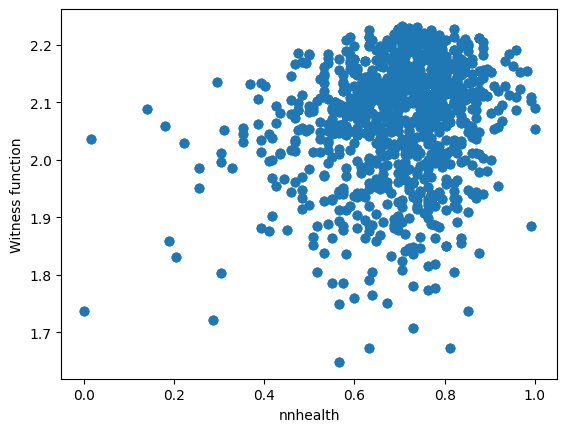

In [32]:
plt.scatter(df_combined[col], witness_fun)
plt.xlabel(f"{COL_NAME_DICT[col]}")
plt.ylabel("Witness function")

Still may have density issue.
#### TODO : check with iid covariates

In [33]:
np.corrcoef(df_combined[col].values, witness_fun)

array([[1.        , 0.20487706],
       [0.20487706, 1.        ]])

Text(0, 0.5, 'Signal difference')

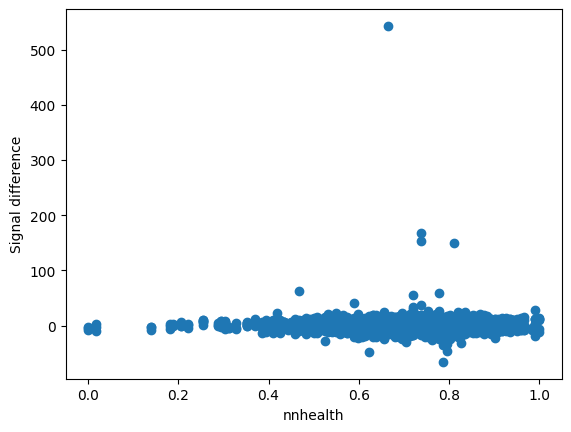

In [34]:
psi = df_combined["S1_cdr_Miss_None_est_CATE"]-df_combined["S0_cdr_Miss_None_est_CATE"]
plt.scatter(df_combined[col], psi)
plt.xlabel(f"{COL_NAME_DICT[col]}")
plt.ylabel("Signal difference")

In [35]:
np.corrcoef(df_combined[col].values, psi)

array([[1.        , 0.03862791],
       [0.03862791, 1.        ]])

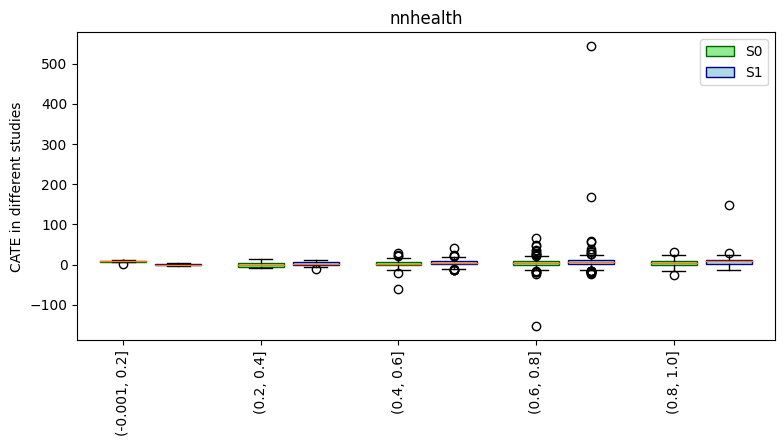

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

ydiff = df_combined["S1_cdr_Miss_None_est_CATE"]-df_combined["S0_cdr_Miss_None_est_CATE"]
x = df_combined[col]
x_unique = x.unique()
if len(x.unique())>5:
    #cat, bins = np.append(np.arange(x.min(),x.max(),step = (x.max()-x.min())/5),x.max())
    x, bins = pd.cut(x,5, retbins=True)
    x_unique = x.cat.categories

mask_S0 = [(x==x_).values * (df_combined["S"]==0).values  for x_ in x_unique]
mask_S1 = [(x==x_).values * (df_combined["S"]==1).values  for x_ in x_unique]

y_list_S0 = [df_combined["S0_cdr_Miss_None_est_CATE"][mask_] for mask_ in mask_S0]
y_list_S1 = [df_combined["S1_cdr_Miss_None_est_CATE"][mask_] for mask_ in mask_S1]

bp1 = ax.boxplot(y_list_S0, positions = 1.5 * np.arange(len(x_unique)), patch_artist=True, boxprops=dict(facecolor='LightGreen', color='DarkGreen'))


bp2 = ax.boxplot(y_list_S1, positions = 1.5 * np.arange(len(x_unique)) + 0.6, patch_artist=True, boxprops=dict(facecolor='LightBlue', color='DarkBlue'))


ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['S0', 'S1'], loc='upper right')

plt.xticks(rotation = 90, ticks = 1.5 * np.arange(len(x_unique)), labels = x_unique)
plt.ylabel("CATE in different studies")
plt.title(f"{COL_NAME_DICT[col]}")
plt.show()

Text(0.5, 1.0, 'nnhealth')

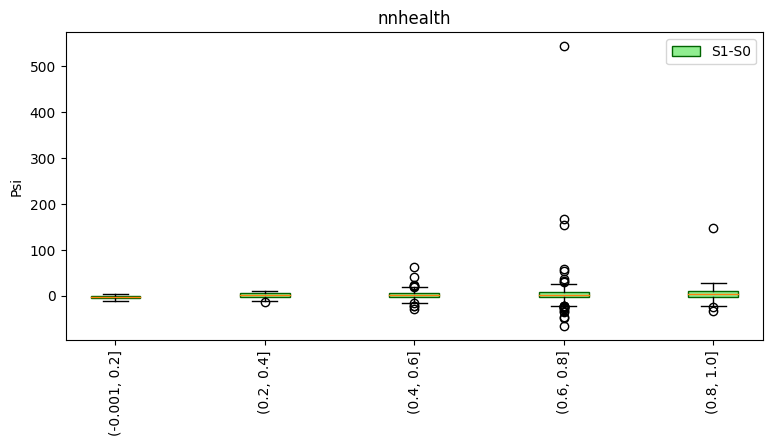

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

ydiff = df_combined["S1_cdr_Miss_None_est_CATE"]-df_combined["S0_cdr_Miss_None_est_CATE"]
x = df_combined[col]
x_unique = x.unique()
if len(x.unique())>5:
    #cat, bins = np.append(np.arange(x.min(),x.max(),step = (x.max()-x.min())/5),x.max())
    x, bins = pd.cut(x,5, retbins=True)
    x_unique = x.cat.categories

mask = [(x==x_).values   for x_ in x_unique]

y_list = [ydiff[mask_] for mask_ in mask]

bp1 = ax.boxplot(y_list, positions = 1.5 * np.arange(len(x_unique)), patch_artist=True, boxprops=dict(facecolor='LightGreen', color='DarkGreen'))


ax.legend([bp1["boxes"][0]], ['S1-S0'], loc='upper right')

plt.xticks(rotation = 90, ticks = 1.5 * np.arange(len(x_unique)), labels = x_unique)
plt.ylabel("Psi")
plt.title(f"{COL_NAME_DICT[col]}")

In [20]:
laplacian_kernel(np.zeros((1,10)),df_combined[COL_NAME_DICT.keys()].values).shape

(1, 2955)

In [23]:
(df_combined["S1_cdr_Miss_None_est_CATE"]-df_combined["S0_cdr_Miss_None_est_CATE"]).values.shape

(2955,)

In [17]:
np.zeros((1,10)).repeat(df_combined.shape[0],0).shape

(2955, 10)

In [13]:
np.zeros((1,10)).shape

(1, 10)

In [6]:
df_combined.columns

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,Y0,Y1,P(S=1|X),"P(A=1|X,S)","P(Delta=1|X,S,A)","mu(Y|X,S,A=0)","mu(Y|X,S,A=1)","Gb(T|X,S,A)",S0_cdr_Miss_None_est_CATE,S1_cdr_Miss_None_est_CATE
0,1.0,-0.5,0.540533,0.615385,0.666667,0.519898,0.5,0.647541,0.333333,-0.5,...,1.020521,6.945653,0.666667,0.565947,0.990597,1.090279,3.679007,1.000000,13.166655,0.000000
1,1.0,-0.5,0.437500,0.153846,0.066667,0.448980,-0.5,0.573770,0.333333,-0.5,...,3.901796,2.011019,0.666667,0.587696,1.000000,0.852869,2.022576,1.000000,-4.886543,0.000000
2,1.0,-0.5,0.312500,0.461538,0.666667,0.234694,-0.5,0.606557,1.000000,-0.5,...,4.362480,3.237487,0.666667,0.541070,1.000000,3.542174,3.243743,1.000000,1.512050,0.000000
3,1.0,-0.5,0.562500,0.307692,0.300000,0.454082,-0.5,0.795082,0.000000,-0.5,...,4.593885,2.270098,0.666667,0.493168,1.000000,3.952065,2.237949,1.000000,-6.024426,0.000000
4,1.0,-0.5,0.687500,0.000000,0.233333,0.736735,-0.5,0.688525,0.000000,-0.5,...,4.539589,4.111943,0.666667,0.498049,1.000000,3.507060,4.134726,1.000000,5.751078,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,1.0,-0.5,0.562500,0.230769,0.633333,0.816327,0.5,0.795082,0.000000,-0.5,...,3.345030,2.507296,0.666667,0.376888,0.859257,2.002963,2.695162,0.970934,0.000000,-6.953202
2951,1.0,-0.5,0.625000,0.076923,0.500000,0.923469,-0.5,0.786885,0.333333,-0.5,...,3.591917,2.566555,0.666667,0.374565,1.000000,3.612762,2.286895,1.000000,0.000000,1.197135
2952,1.0,-0.5,0.562500,0.076923,0.500000,0.576531,0.5,0.901639,0.000000,-0.5,...,2.600302,8.476102,0.666667,0.812982,0.551552,1.971579,6.969588,0.338859,0.000000,10.339927
2953,1.0,-0.5,0.687500,0.307692,0.433333,0.612245,0.5,0.754098,0.000000,-0.5,...,3.372209,4.504489,0.666667,0.398719,1.000000,3.506471,3.457468,1.000000,0.000000,1.988332


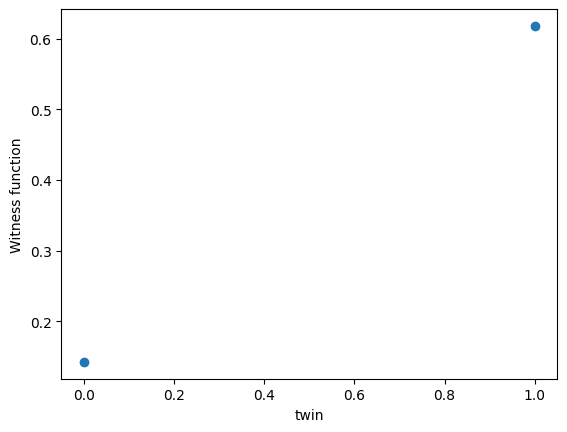

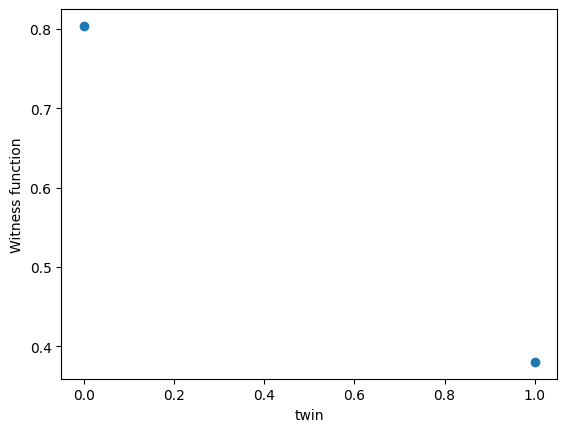

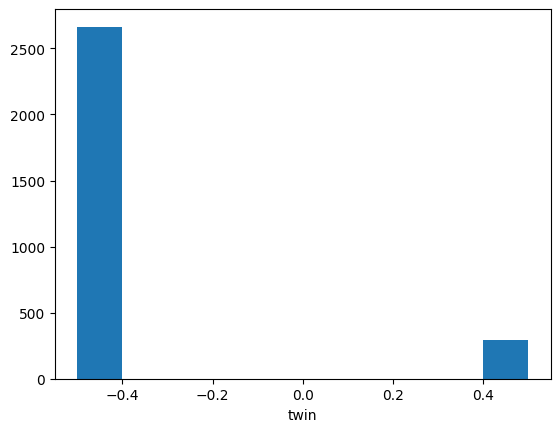

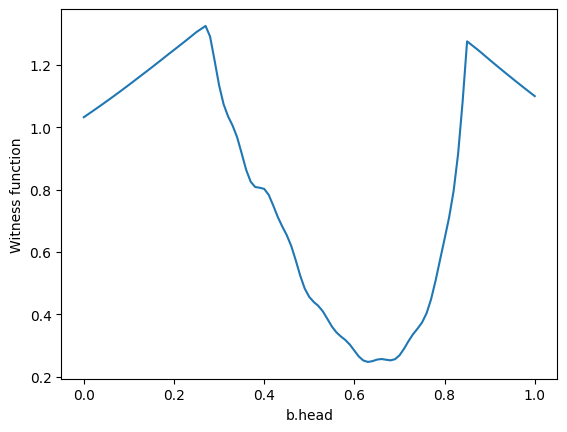

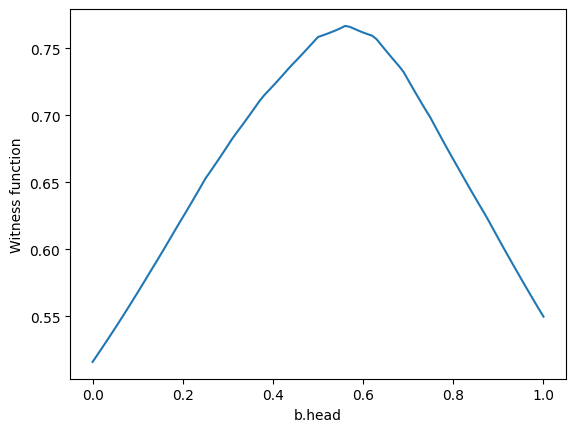

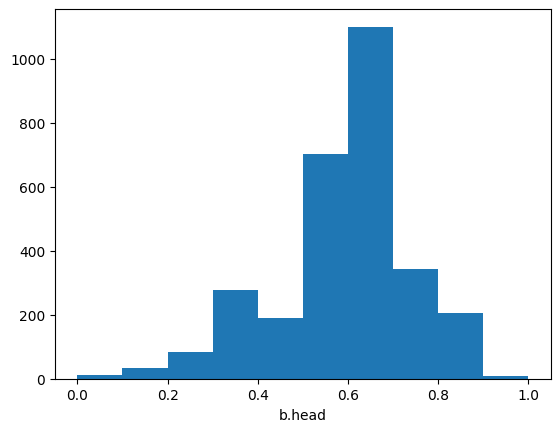

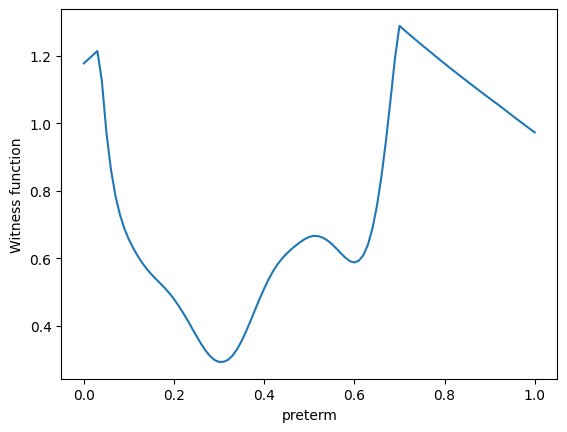

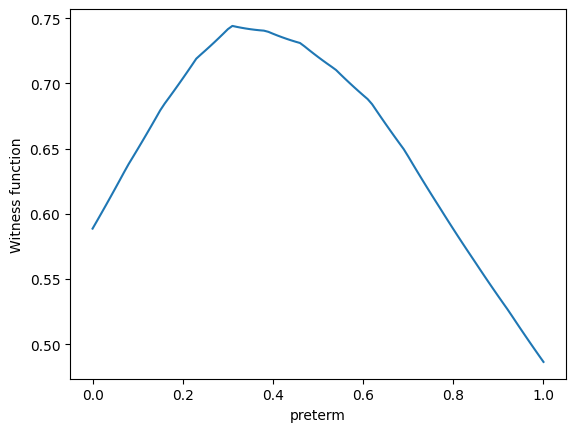

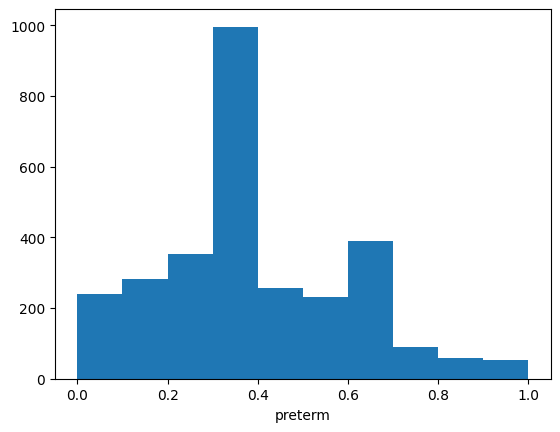

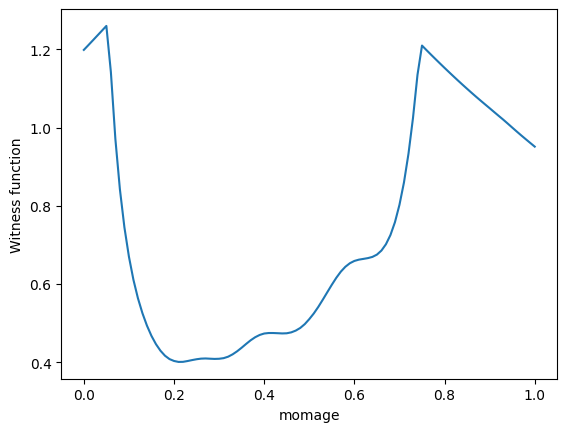

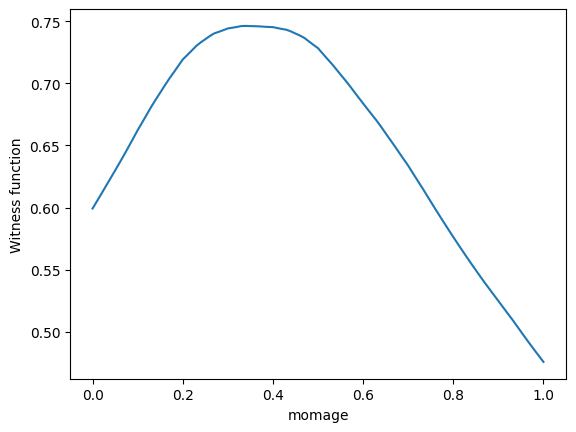

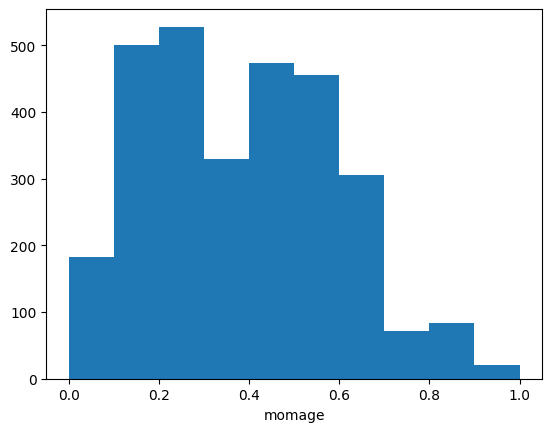

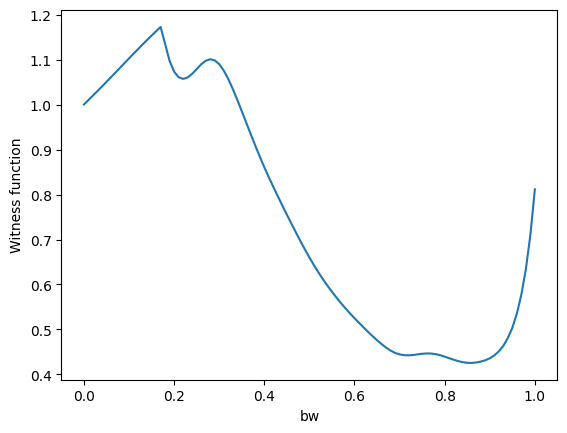

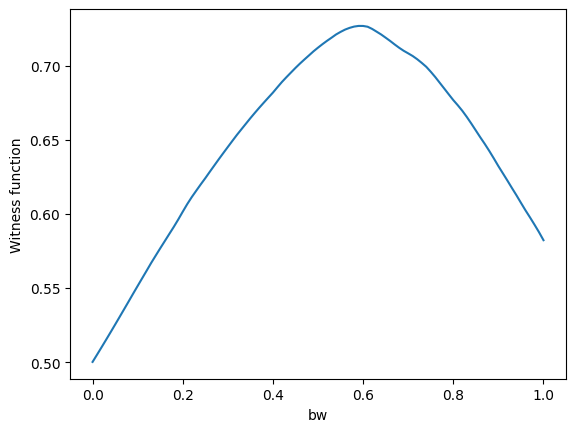

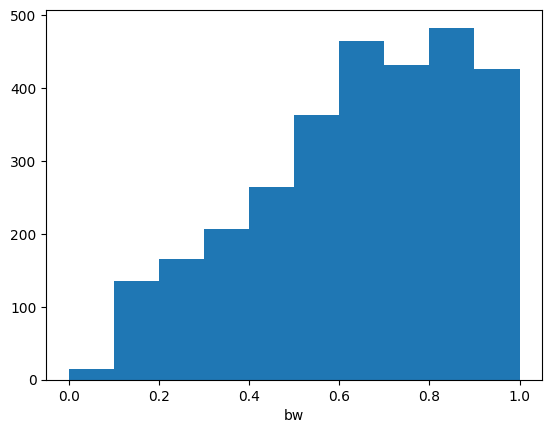

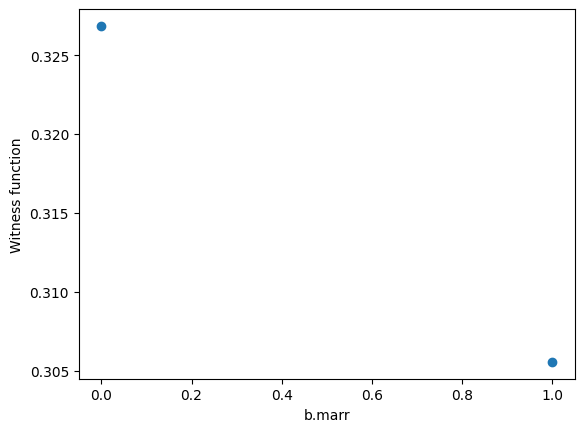

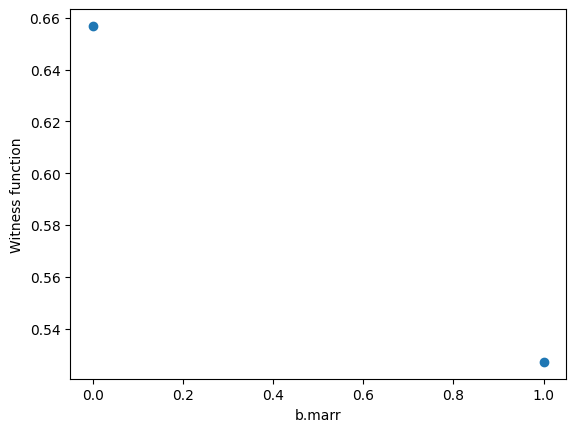

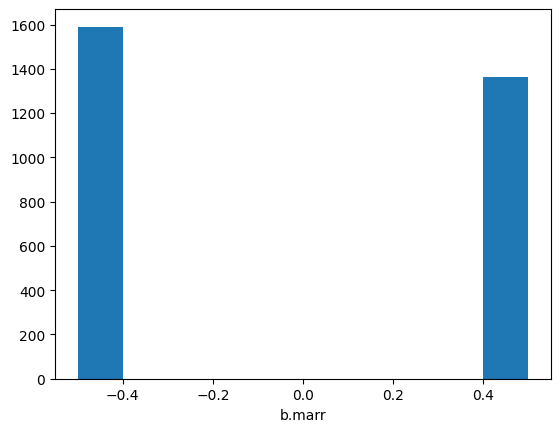

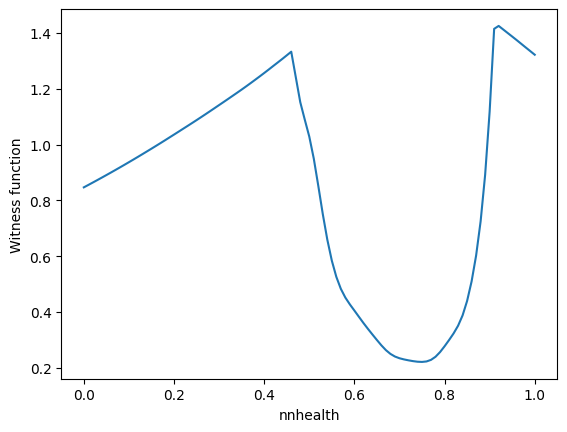

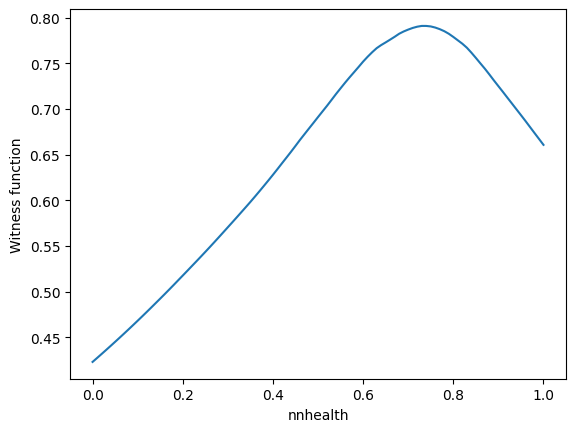

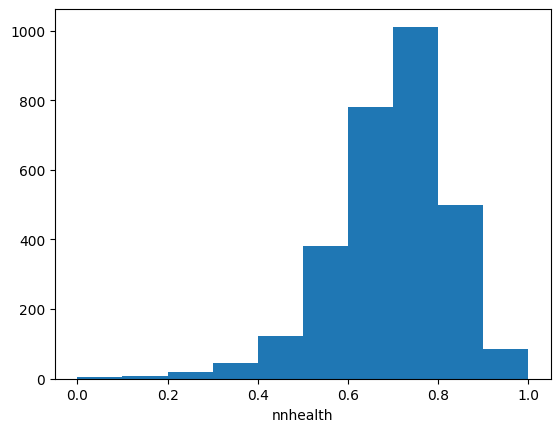

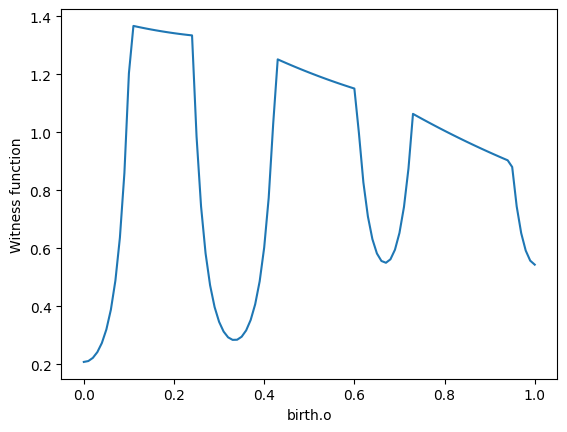

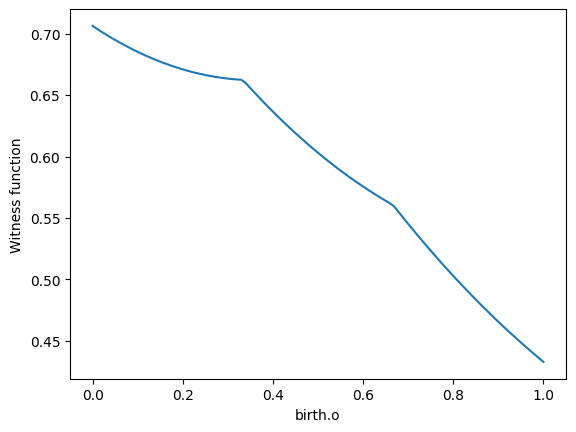

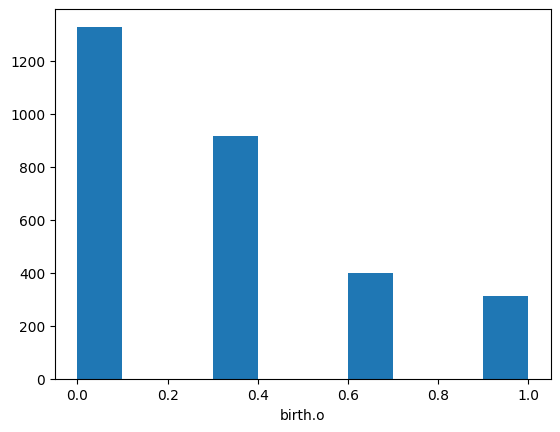

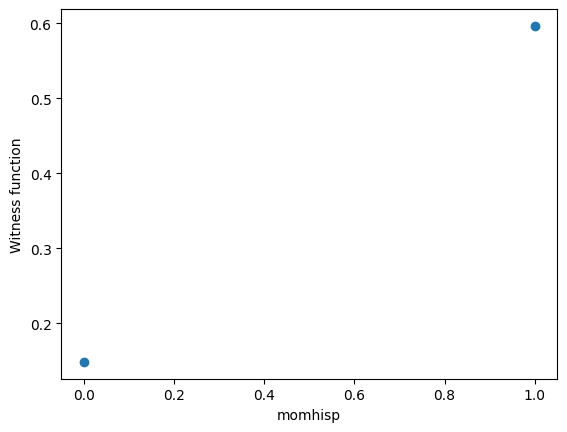

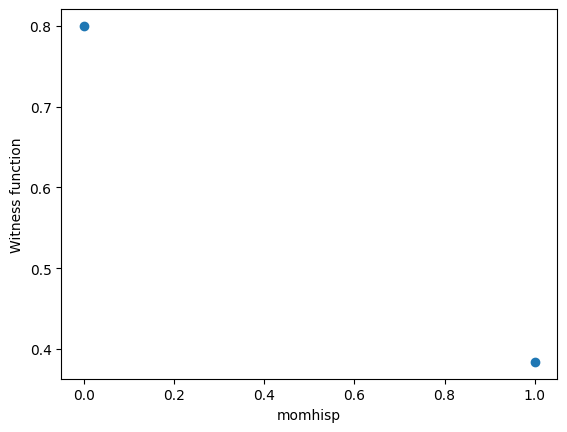

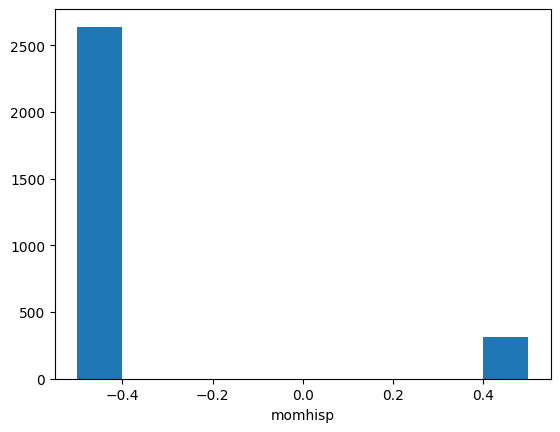

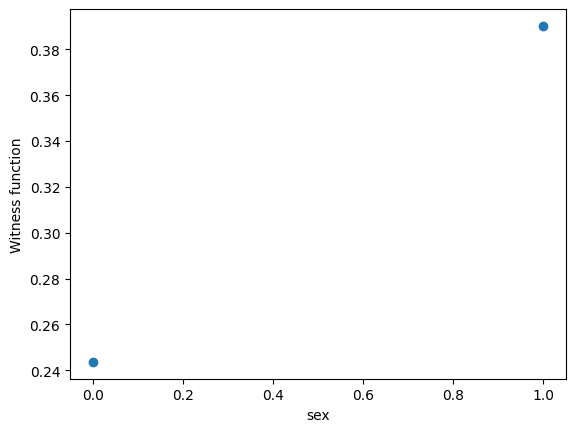

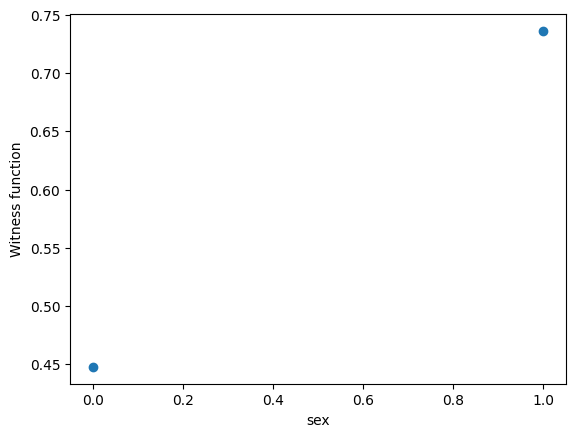

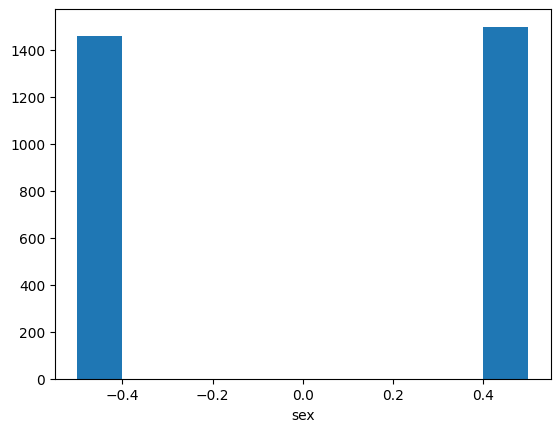

In [5]:
for xname in COL_NAME_DICT.keys():
    plot_wit_fn(df_combined, laplacian_kernel, xname, "S0_cdr_Miss_None_est_CATE", "S1_cdr_Miss_None_est_CATE", plot_marg=False, weight_marg=True)
    plot_wit_fn(df_combined, laplacian_kernel, xname, "S0_cdr_Miss_None_est_CATE", "S1_cdr_Miss_None_est_CATE", plot_marg=True, weight_marg=False)